In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import math

In [2]:
# Load and preprocess MNIST data
def load_and_preprocess_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # Normalize images
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    # Reshape for convolution (add channel dimension)
    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)
    
    # One-hot encode labels
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)
    
    return (x_train, y_train), (x_test, y_test)

In [3]:
# Create a custom rotation equivariant layer
class RotationEquivariantLayer(keras.layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(RotationEquivariantLayer, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        
    def build(self, input_shape):
        # Create a single set of weights that will be shared
        self.kernel = self.add_weight(
            shape=(self.kernel_size, self.kernel_size, input_shape[-1], self.filters),
            initializer='glorot_uniform',
            trainable=True,
            name='kernel'
        )
        self.bias = self.add_weight(
            shape=(self.filters,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )
        super(RotationEquivariantLayer, self).build(input_shape)
        
    def call(self, inputs):
        # Original orientation (0 degrees)
        out_0 = tf.nn.conv2d(
            inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME')
        
        # Rotate input by 90 degrees
        inputs_90 = tf.image.rot90(inputs)
        out_90 = tf.nn.conv2d(
            inputs_90, self.kernel, strides=[1, 1, 1, 1], padding='SAME')
        out_90 = tf.image.rot90(out_90, k=3)  # Rotate back
        
        # Rotate input by 180 degrees
        inputs_180 = tf.image.rot90(inputs_90)
        out_180 = tf.nn.conv2d(
            inputs_180, self.kernel, strides=[1, 1, 1, 1], padding='SAME')
        out_180 = tf.image.rot90(out_180, k=2)  # Rotate back
        
        # Rotate input by 270 degrees
        inputs_270 = tf.image.rot90(inputs_180)
        out_270 = tf.nn.conv2d(
            inputs_270, self.kernel, strides=[1, 1, 1, 1], padding='SAME')
        out_270 = tf.image.rot90(out_270, k=1)  # Rotate back
        
        # Weight sharing across rotations - average the outputs
        out = (out_0 + out_90 + out_180 + out_270) / 4.0
        
        # Add bias
        out = tf.nn.bias_add(out, self.bias)
        
        return out
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2], self.filters)

In [4]:
def create_equivariant_model():
    inputs = keras.Input(shape=(28, 28, 1))
    
    # First rotation equivariant layer
    x = RotationEquivariantLayer(filters=32, kernel_size=3)(inputs)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Second rotation equivariant layer
    x = RotationEquivariantLayer(filters=64, kernel_size=3)(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Flatten and classify
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    
    return keras.Model(inputs=inputs, outputs=outputs)

def create_baseline_model():
    model = models.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

In [5]:
def create_rotated_mnist():
    (x_train, y_train), (x_test, y_test) = load_and_preprocess_mnist()
    
    # Create arrays for rotated images and corresponding labels
    rotations = [0, 90, 180, 270]
    train_images_rotated = []
    test_images_rotated = []
    
    # Rotate training images
    for i in range(len(x_train)):
        rotation = rotations[i % 4]
        if rotation == 0:
            train_images_rotated.append(x_train[i])
        else:
            # Convert to int to indicate number of counterclockwise rotations
            k = rotation // 90
            rotated_img = tf.image.rot90(x_train[i], k=k).numpy()
            train_images_rotated.append(rotated_img)
    
    # Rotate test images
    for i in range(len(x_test)):
        rotation = rotations[i % 4]
        if rotation == 0:
            test_images_rotated.append(x_test[i])
        else:
            # Convert to int to indicate number of counterclockwise rotations
            k = rotation // 90
            rotated_img = tf.image.rot90(x_test[i], k=k).numpy()
            test_images_rotated.append(rotated_img)
    
    x_train_rotated = np.array(train_images_rotated)
    x_test_rotated = np.array(test_images_rotated)
    
    return (x_train_rotated, y_train), (x_test_rotated, y_test)

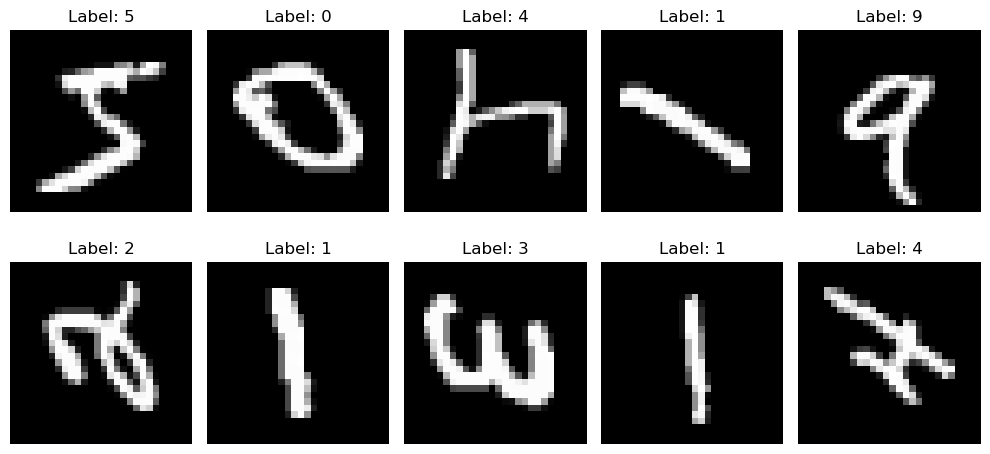

In [6]:

# Load and create rotated MNIST dataset
(x_train_rotated, y_train), (x_test_rotated, y_test) = create_rotated_mnist()

def visualize_rotated_samples(x_rotated, y):
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(x_rotated[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {np.argmax(y[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize some samples
visualize_rotated_samples(x_train_rotated, y_train)



Equivariant Model Summary:


/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rotation_equivariant_layer      │ (None, 28, 28, 32)     │           320 │
│ (RotationEquivariantLayer)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rotation_equivariant_layer_1    │ (None, 14, 14, 64)     │        18,496 │
│ (RotationEquivariantLayer)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)


Baseline Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 535,818 (2.04 MB)

 Trainable params: 535,818 (2.04 MB)

 Non-trainable params: 0 (0.00 B)


Training Equivariant Model...
Epoch 1/10


W0000 00:00:1741790147.959534 2404883 loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/functional_1/rotation_equivariant_layer_1_2/rot90_1/Assert/AssertGuard/branch_executed/_176


422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5265 - loss: 1.3577

W0000 00:00:1741790173.692355 2404883 loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: functional_1/rotation_equivariant_layer_1/rot90/Assert/AssertGuard/branch_executed/_8


422/422 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.5268 - loss: 1.3568 - val_accuracy: 0.8447 - val_loss: 0.5206
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 626s 1s/step - accuracy: 0.8287 - loss: 0.5527 - val_accuracy: 0.8967 - val_loss: 0.3451
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 32s 76ms/step - accuracy: 0.8836 - loss: 0.3792 - val_accuracy: 0.9097 - val_loss: 0.2975
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 70ms/step - accuracy: 0.9098 - loss: 0.2934 - val_accuracy: 0.9312 - val_loss: 0.2328
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9251 - loss: 0.2408 - val_accuracy: 0.9280 - val_loss: 0.2426
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9380 - loss: 0.2010 - val_accuracy: 0.9423 - val_loss: 0.1910
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.9500 - loss: 0.1658 - val_accuracy: 0.9377 - val_loss: 0.2039
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.9529 - loss: 0.1488 - val_accuracy

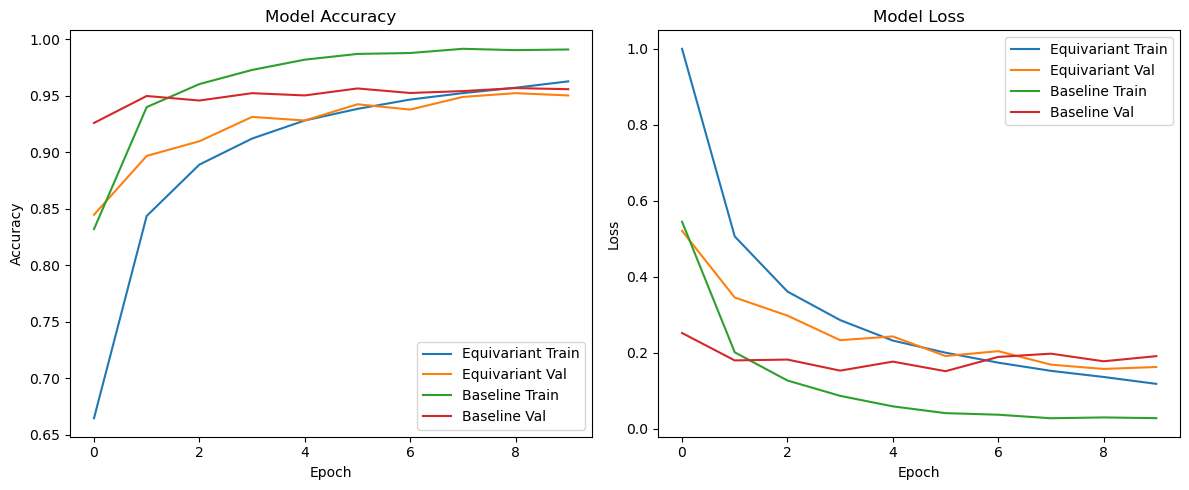

In [7]:


# Create models
equivariant_model = create_equivariant_model()
baseline_model = create_baseline_model()

# Compile models
equivariant_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summaries
print("Equivariant Model Summary:")
equivariant_model.summary()

print("\nBaseline Model Summary:")
baseline_model.summary()

# Train equivariant model
print("\nTraining Equivariant Model...")
equivariant_history = equivariant_model.fit(
    x_train_rotated, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

# Train baseline model
print("\nTraining Baseline Model...")
baseline_history = baseline_model.fit(
    x_train_rotated, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

# Evaluate models
print("\nEvaluating Equivariant Model...")
equivariant_loss, equivariant_acc = equivariant_model.evaluate(x_test_rotated, y_test)
print(f"Equivariant Model - Test Accuracy: {equivariant_acc:.4f}")

print("\nEvaluating Baseline Model...")
baseline_loss, baseline_acc = baseline_model.evaluate(x_test_rotated, y_test)
print(f"Baseline Model - Test Accuracy: {baseline_acc:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(equivariant_history.history['accuracy'], label='Equivariant Train')
plt.plot(equivariant_history.history['val_accuracy'], label='Equivariant Val')
plt.plot(baseline_history.history['accuracy'], label='Baseline Train')
plt.plot(baseline_history.history['val_accuracy'], label='Baseline Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(equivariant_history.history['loss'], label='Equivariant Train')
plt.plot(equivariant_history.history['val_loss'], label='Equivariant Val')
plt.plot(baseline_history.history['loss'], label='Baseline Train')
plt.plot(baseline_history.history['val_loss'], label='Baseline Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

